# 简介

该代码基于English-French parallel corpus实现了机器翻译模型，模型在基础的Seq2Seq模型上加入Attention机制与BiRNN。代码采用Keras框架实现。

# 1 - 加载包

In [1]:
import warnings
warnings.filterwarnings("ignore")

from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, Reshape
from keras.layers import RepeatVector, Dense, Activation, Lambda, Embedding
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import keras
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__

'2.0.9'

# 2 - 加载数据

## 2.1 - 加载源数据

In [3]:
# English source data
with open("data/small_vocab_en", "r", encoding="utf-8") as f:
    source_text = f.read()

# French target data
with open("data/small_vocab_fr", "r", encoding="utf-8") as f:
    target_text = f.read()

## 2.2 - 数据统计

对语料数据进行统计性分析：
- 对英文语料：统计句子数、平均句子长度以及最大句子长度
- 对法语语料：统计句子数、平均句子长度以及最大句子长度
- 打印语料数据

In [4]:
view_sentence_range = (0, 10)

# Separate the source language text by spaces, to see how many distinct words are contained in it
print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in source_text.split()})))

# 统计英文语料数据
print("-"*5 + "English Text" + "-"*5)
sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of sentences: {}'.format(len(sentences)))
print('Average number of words in a sentence: {}'.format(np.average(word_counts)))
print('Max number of words in a sentence: {}'.format(np.max(word_counts)))

# 统计法语语料数据
print()
print("-"*5 + "French Text" + "-"*5)
sentences = target_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of sentences: {}'.format(len(sentences)))
print('Average number of words in a sentence: {}'.format(np.average(word_counts)))
print('Max number of words in a sentence: {}'.format(np.max(word_counts)))

# 打印语料的前10个句子
print()
print('English sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))
print()
print('French sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 227
-----English Text-----
Number of sentences: 137861
Average number of words in a sentence: 13.225277634719028
Max number of words in a sentence: 17

-----French Text-----
Number of sentences: 137861
Average number of words in a sentence: 14.226612312401622
Max number of words in a sentence: 23

English sentences 0 to 10:
new jersey is sometimes quiet during autumn , and it is snowy in april .
the united states is usually chilly during july , and it is usually freezing in november .
california is usually quiet during march , and it is usually hot in june .
the united states is sometimes mild during june , and it is cold in september .
your least liked fruit is the grape , but my least liked is the apple .
his favorite fruit is the orange , but my favorite is the grape .
paris is relaxing during december , but it is usually chilly in july .
new jersey is busy during spring , and it is never hot in march .
our least liked fruit is the l

## 2.3 - 数据预处理

数据预处理部分主要包括：
- 构造英文与法语的词典
- 构造语料单词到编码的映射

In [5]:
# 构造英文词典
source_vocab = list(set(source_text.lower().split()))
# 构造法语词典
target_vocab = list(set(target_text.lower().split()))

In [6]:
print("The size of English vocab is : {}".format(len(source_vocab)))
print("The size of French vocab is : {}".format(len(target_vocab)))

The size of English vocab is : 227
The size of French vocab is : 354


In [7]:
# 增加特殊编码
SOURCE_CODES = ['<PAD>', '<UNK>']
TARGET_CODES = ['<PAD>', '<EOS>', '<UNK>', '<GO>']

In [8]:
# 构造英文语料的映射表
source_vocab_to_int = {word: idx for idx, word in enumerate(SOURCE_CODES + source_vocab)}
source_int_to_vocab = {idx: word for idx, word in enumerate(SOURCE_CODES + source_vocab)}

# 构造法语语料的映射表
target_vocab_to_int = {word: idx for idx, word in enumerate(TARGET_CODES + target_vocab)}
target_int_to_vocab = {idx: word for idx, word in enumerate(TARGET_CODES + target_vocab)}

In [9]:
print("The size of English Map is : {}".format(len(source_vocab_to_int)))
print("The size of French Map is : {}".format(len(target_vocab_to_int)))

The size of English Map is : 229
The size of French Map is : 358


## 2.4 - 语料转换

在构造完英文与法语映射表的基础上，我们此时将原始文本语料转化为数字编码。

例如， 对句子 ”I love machine learning and deep learning" ，我们可以编码为 [28, 29, 274, 873, 12, 983, 873, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] （其中0代表< PAD >)

In [10]:
def text_to_int(sentence, map_dict, max_length=20, is_target=False):
    """
    Encoding the text into integers.
    
    @param sentence: 完整的句子，str类型
    @param map_dict: 单词到数字编码的映射
    @param max_length: 最大句子长度
    @param is_target: 当前传入的句子是否是目标语句。
                      对于目标语句，我们要在末尾添加"<EOS>"
    """
    
    text_to_idx = []
    # 特殊单词的数字编码
    unk_idx = map_dict.get("<UNK>")
    pad_idx = map_dict.get("<PAD>")
    eos_idx = map_dict.get("<EOS>")
    
    # 如果不是目标语句（即源语句）
    if not is_target:
        for word in sentence.split():
            text_to_idx.append(map_dict.get(word, unk_idx))
    
    # 目标语句要对结尾添加"<EOS>"
    else:
        for word in sentence.split():
            text_to_idx.append(map_dict.get(word, unk_idx))
        text_to_idx.append(eos_idx)
    
    # 超长句子进行截断
    if len(text_to_idx) > max_length:
        return text_to_idx[:max_length]
    # 不足长度的句子进行"<PAD>"
    else:
        text_to_idx = text_to_idx + [pad_idx] * (max_length - len(text_to_idx))
        return text_to_idx

In [11]:
# 对英文语料进行编码，其中设置英文句子最大长度为20
Tx = 20
source_text_to_int = []

for sentence in tqdm.tqdm(source_text.split("\n")):
    source_text_to_int.append(text_to_int(sentence, source_vocab_to_int, Tx, is_target=False))

100%|██████████| 137861/137861 [00:00<00:00, 147724.24it/s]


In [12]:
# 对法语语料进行编码，其中设置法语句子最大长度为25
Ty = 25
target_text_to_int = []

for sentence in tqdm.tqdm(target_text.split("\n")):
    target_text_to_int.append(text_to_int(sentence, target_vocab_to_int, Ty, is_target=True))

100%|██████████| 137861/137861 [00:01<00:00, 121571.41it/s]


In [13]:
random_index = 77

print("-"*5 + "English example" + "-"*5)
print(source_text.split("\n")[random_index])
print(source_text_to_int[random_index])

print()
print("-"*5 + "French example" + "-"*5)
print(target_text.split("\n")[random_index])
print(target_text_to_int[random_index])

-----English example-----
the united states is never beautiful during march , and it is usually relaxing in summer .
[191, 174, 51, 156, 73, 193, 118, 28, 93, 39, 203, 156, 29, 148, 184, 205, 171, 0, 0, 0]

-----French example-----
les états-unis est jamais belle en mars , et il est relaxant habituellement en été .
[339, 82, 291, 59, 162, 158, 143, 41, 118, 173, 291, 290, 95, 158, 57, 255, 1, 0, 0, 0, 0, 0, 0, 0, 0]


**After encoding the source and target text into numbers, we need to do one-hot-encoding of them**

In [14]:
from keras.utils import to_categorical

In [15]:
X = np.array(source_text_to_int)
Y = np.array(target_text_to_int)

In [16]:
# 对X和Y做One Hot Encoding
Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(source_vocab_to_int)), X)))
Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(target_vocab_to_int)), Y)))

# 3 - 构造模型

In [17]:
# 自定义softmax函数
def softmax(x, axis=1):
    """
    Softmax activation function.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [18]:
# 定义全局网络层对象
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor_tanh = Dense(32, activation = "tanh")
densor_relu = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes = 1)

## 3.1 - Attention

In [19]:
def one_step_attention(a, s_prev):
    """
    Attention机制的实现，返回加权后的Context Vector
    
    @param a: BiRNN的隐层状态
    @param s_prev: Decoder端LSTM的上一轮隐层输出
    
    Returns:
    context: 加权后的Context Vector
    """
    
    # 将s_prev复制Tx次
    s_prev = repeator(s_prev)
    # 拼接BiRNN隐层状态与s_prev
    concat = concatenator([a, s_prev])
    # 计算energies
    e = densor_tanh(concat)
    energies = densor_relu(e)
    # 计算weights
    alphas = activator(energies)
    # 加权得到Context Vector
    context = dotor([alphas, a])
    
    return context

## 3.2 - 模型

主要包括：

- Embedding层
- Seq2Seq模型

### 3.2.1 - 构造Embedding层

In [20]:
# 加载预训练好的glove词向量
with open("data/glove.6B.100d.txt", 'r') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
        line = line.strip().split()
        curr_word = line[0]
        words.add(curr_word)
        word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

In [21]:
def pretrained_embedding_layer(word_to_vec_map, source_vocab_to_int):
    """
    构造Embedding层并加载预训练好的词向量（这里我使用的是100维）

    @param word_to_vec_map: 单词到向量的映射
    @param word_to_index: 单词到数字编码的映射
    """
    
    vocab_len = len(source_vocab_to_int) + 1        # Keras Embedding的API要求+1
    emb_dim = word_to_vec_map["the"].shape[0]
    
    # 初始化embedding矩阵
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # 用词向量填充embedding矩阵
    for word, index in source_vocab_to_int.items():
        word_vector = word_to_vec_map.get(word, np.zeros(emb_dim))
        emb_matrix[index, :] = word_vector

    # 定义Embedding层，并指定不需要训练该层的权重
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    # build
    embedding_layer.build((None,))
    
    # set weights
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [22]:
# 获取Embedding layer
embedding_layer = pretrained_embedding_layer(word_to_vec_map, source_vocab_to_int)

### 3.2.2 - 定义超参数与模型

In [23]:
n_a = 32 # The hidden size of Bi-LSTM
n_s = 128 # The hidden size of LSTM in Decoder
decoder_LSTM_cell = LSTM(n_s, return_state=True)
output_layer = Dense(len(target_vocab_to_int), activation=softmax)

In [24]:
# 定义网络层对象（用在model函数中）
reshapor = Reshape((1, len(target_vocab_to_int)))
concator = Concatenate(axis=-1)

In [25]:
def model(Tx, Ty, n_a, n_s, source_vocab_size, target_vocab_size):
    """
    构造模型
    
    @param Tx: 输入序列的长度
    @param Ty: 输出序列的长度
    @param n_a: Encoder端Bi-LSTM隐层结点数
    @param n_s: Decoder端LSTM隐层结点数
    @param source_vocab_size: 输入（英文）语料的词典大小
    @param target_vocab_size: 输出（法语）语料的词典大小
    """
    
    # 定义输入层
    X = Input(shape=(Tx,))
    # Embedding层
    embed = embedding_layer(X)
    # Decoder端LSTM的初始状态
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    
    # Decoder端LSTM的初始输入
    out0 = Input(shape=(target_vocab_size, ), name='out0')
    out = reshapor(out0)
    
    s = s0
    c = c0
    
    # 模型输出列表，用来存储翻译的结果
    outputs = []
    
    # 定义Bi-LSTM
    a = Bidirectional(LSTM(n_a, return_sequences=True))(embed)
    
    # Decoder端，迭代Ty轮，每轮生成一个翻译结果
    for t in range(Ty):
    
        # 获取Context Vector
        context = one_step_attention(a, s)
        
        # 将Context Vector与上一轮的翻译结果进行concat
        context = concator([context, reshapor(out)])
        s, _, c = decoder_LSTM_cell(context, initial_state=[s, c])
        
        # 将LSTM的输出结果与全连接层链接
        out = output_layer(s)
        
        # 存储输出结果
        outputs.append(out)
    
    model = Model([X, s0, c0, out0], outputs)
    
    return model

In [26]:
model = model(Tx, Ty, n_a, n_s, len(source_vocab_to_int), len(target_vocab_to_int))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 100)      23000       input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 128)          0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 64)       34048       embedding_1[0][0]                
__________________________________________________________________________________________________
repeat_vec

In [28]:
out = model.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001),
                    metrics=['accuracy'],
                    loss='categorical_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
# model.load_weights("pretrained_seq2seq_model.h5")

In [29]:
# 初始化各类向量
m = X.shape[0]
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
out0 = np.zeros((m, len(target_vocab_to_int)))
outputs = list(Yoh.swapaxes(0,1))

In [30]:
# 训练模型
model.fit([X, s0, c0, out0], outputs, epochs=5, batch_size=128)

Epoch 1/5
137861/137861 [==============================] - 374s 3ms/step - loss: 28.3369 - dense_3_loss_1: 1.1297 - dense_3_loss_2: 1.1169 - dense_3_loss_3: 1.1193 - dense_3_loss_4: 2.1534 - dense_3_loss_5: 1.9711 - dense_3_loss_6: 1.8172 - dense_3_loss_7: 2.0715 - dense_3_loss_8: 1.5230 - dense_3_loss_9: 1.4096 - dense_3_loss_10: 1.6867 - dense_3_loss_11: 1.7546 - dense_3_loss_12: 1.9988 - dense_3_loss_13: 1.9940 - dense_3_loss_14: 1.8036 - dense_3_loss_15: 1.6738 - dense_3_loss_16: 1.1921 - dense_3_loss_17: 0.8301 - dense_3_loss_18: 0.5120 - dense_3_loss_19: 0.2486 - dense_3_loss_20: 0.1094 - dense_3_loss_21: 0.0561 - dense_3_loss_22: 0.0438 - dense_3_loss_23: 0.0412 - dense_3_loss_24: 0.0405 - dense_3_loss_25: 0.0401 - dense_3_acc_1: 0.6519 - dense_3_acc_2: 0.6899 - dense_3_acc_3: 0.7008 - dense_3_acc_4: 0.3800 - dense_3_acc_5: 0.4822 - dense_3_acc_6: 0.5080 - dense_3_acc_7: 0.4361 - dense_3_acc_8: 0.5734 - dense_3_acc_9: 0.5671 - dense_3_acc_10: 0.5063 - dense_3_acc_11: 0.5255 - de

In [64]:
# 保存参数
model.save_weights("pretrained_seq2seq_model.h5")

## 3.3 预测

In [31]:
# Have a look at source text
source_text.split("\n")[:100]

['new jersey is sometimes quiet during autumn , and it is snowy in april .',
 'the united states is usually chilly during july , and it is usually freezing in november .',
 'california is usually quiet during march , and it is usually hot in june .',
 'the united states is sometimes mild during june , and it is cold in september .',
 'your least liked fruit is the grape , but my least liked is the apple .',
 'his favorite fruit is the orange , but my favorite is the grape .',
 'paris is relaxing during december , but it is usually chilly in july .',
 'new jersey is busy during spring , and it is never hot in march .',
 'our least liked fruit is the lemon , but my least liked is the grape .',
 'the united states is sometimes busy during january , and it is sometimes warm in november .',
 'the lime is her least liked fruit , but the banana is my least liked .',
 'he saw a old yellow truck .',
 'india is rainy during june , and it is sometimes warm in november .',
 'that cat was my most l

In [32]:
def make_prediction(sentence):
    """
    对给定的句子进行翻译
    """
    # 将句子分词后转化为数字编码
    unk_idx = source_vocab_to_int["<UNK>"]
    word_idx = [source_vocab_to_int.get(word, unk_idx) for word in sentence.lower().split()]
    
    word_idx = np.array(word_idx + [0] * (20 - len(word_idx)))
    
    # 翻译结果
    preds = model.predict([word_idx.reshape(-1,20), s0, c0, out0])
    predictions = np.argmax(preds, axis=-1)
    
    # 转换为单词
    idx = [target_int_to_vocab.get(idx[0], "<UNK>") for idx in predictions]
    
    # 返回句子
    return " ".join(idx)

In [42]:
your_sentence = input("Please input your sentences: ")

Please input your sentences: she likes mangoes , apples , and bananas .


In [43]:
make_prediction(your_sentence)

'elle aime les mangues , les pommes et les bananes . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

# 4 可视化Attention

In [35]:
import seaborn as sns

In [67]:
def plot_attention(sentence, Tx=20, Ty=25):
    """
    可视化Attention层
    
    @param sentence: 待翻译的句子，str类型
    @param Tx: 输入句子的长度
    @param Ty: 输出句子的长度
    """

    X = np.array(text_to_int(sentence, source_vocab_to_int))
    f = K.function(model.inputs, [model.layers[9].get_output_at(t) for t in range(Ty)])
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    out0 = np.zeros((1, len(target_vocab_to_int)))
    
    r = f([X.reshape(-1,20), s0, c0, out0])
    
    attention_map = np.zeros((Ty, Tx))
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime, 0]
    
    Y = make_prediction(sentence)
    
    source_list = sentence.split()
    target_list = Y.split()
    
    f, ax = plt.subplots(figsize=(20,15))
    sns.heatmap(attention_map, xticklabels=source_list, yticklabels=target_list, cmap="YlGnBu")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

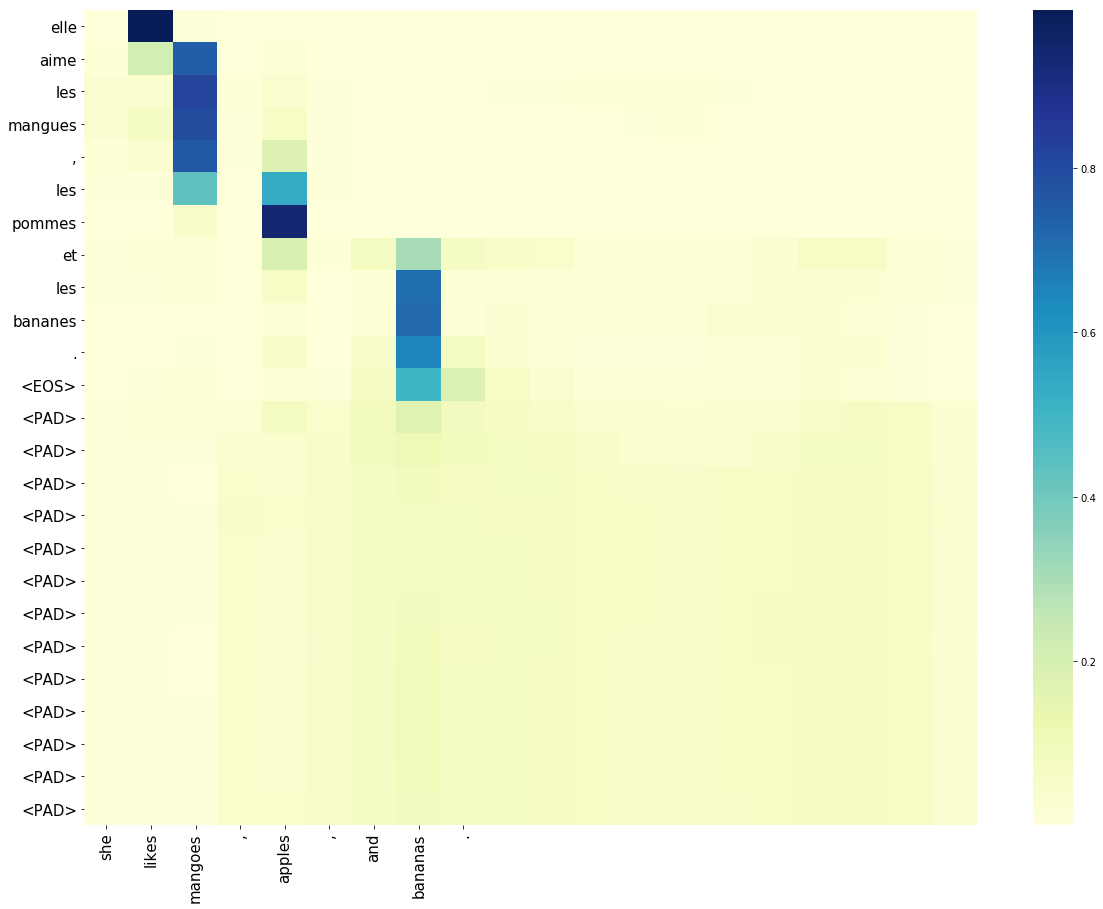

In [68]:
plot_attention("she likes mangoes , apples , and bananas .")

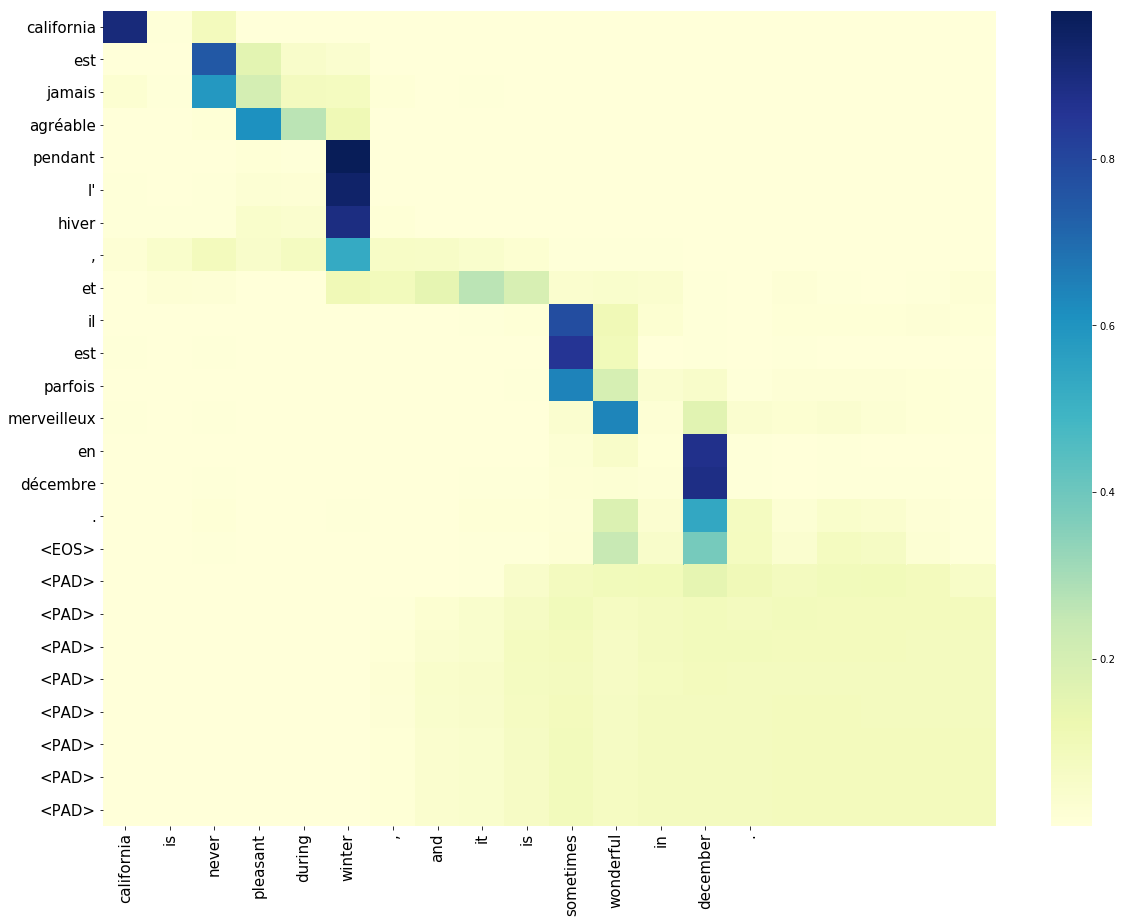

In [69]:
plot_attention("california is never pleasant during winter , and it is sometimes wonderful in december .")

# 5 BLEU评估

采用n-gram的BLEU(Bilingual Evaluation Understudy)来对翻译结果进行评估

In [45]:
from nltk.translate.bleu_score import sentence_bleu

In [49]:
# 存储每个句子的模型翻译结果
fr_preds = []

# 对样本中的每个英文进行翻译
for sentence in tqdm.tqdm(source_text.split("\n")):
    fr_pred = make_prediction(sentence)
    # 存储翻译结果
    fr_preds.append(fr_pred)

100%|██████████| 137861/137861 [30:36<00:00, 75.07it/s]


In [70]:
# 以样本中的法语翻译结果为reference
references = target_text.split("\n")

In [71]:
# 存储每个句子的BLEU分数
bleu_score = []

for i in tqdm.tqdm(range(len(fr_preds))):
    # 去掉特殊字符
    pred = fr_preds[i].replace("<EOS>", "").replace("<PAD>", "").rstrip()
    reference = references[i].lower()
    # 计算BLEU分数
    score = sentence_bleu([reference.split()], pred.split())
    
    bleu_score.append(score)

100%|██████████| 137861/137861 [00:28<00:00, 4883.46it/s]


In [72]:
print("The BLEU score on our corpus is about {}".format(sum(bleu_score) / len(bleu_score)))

The BLEU score on our corpus is about 0.8982868347837505
